# Direct mixture separation

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file_1 = "../data/airco.wav"   # specify sound location of first mixture component
sound_file_2 = "../data/woman.wav"      # specify sound location of second mixture component
fs_desired = 8000                   # specify desired sampling frequency

# parameter loading
param_file_1 = "inferred_values/airco_AR20.h5"

# inference and modelling
AR_order = 20                         # order of auto-regressive model
iterations = 3                       # number of iterations for variational message passing
Λ_meas = 1e1                        # assumed precision of measurement noise
;

## Load and preprocess data

In [3]:
# load and process first mixture component
x_1, fs_1 = wavread(sound_file_1, format="native")
fs_1 = Int(fs_1)
x_1 = x_1[0*fs_1+1:3*fs_1]
x_1 = resample(x_1, fs_desired/fs_1)
x_1 = 20*x_1/var(x_1)

# load and process second mixture component
x_2, fs_2 = wavread(sound_file_2, format="native")
fs_2 = Int(fs_2)
x_2 = x_2[2*fs_2+1:5*fs_2]
x_2 = resample(x_2, fs_desired/fs_2)
x_2 = 50*x_2/var(x_2)

# Combine signals through simple addition
x_tot = x_1 + x_2

# create time axis
t = collect((1:length(x_tot))/fs_desired)

# create audio players for demonstration
audioplayers(x_1, x_2, x_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQA3ciI4gWE6OZOvsbksr7k5BEaJOWYRAjqjBC+6USUuOdnlrbp2mKu5RE7nuioAEryRdV48GavLPKRIwbwEwqq8PrY2PCR3FDz4P2o6Mj+4vCqFA70Z00K8ZN7hPCWDTj1B5hM9NJqzPMVr6LyqDC+9HdF4vL85SD0pZu48tr4MvUqeAL1Hb7e8c2qFvFGDzLxuiwa8ZHd3vKJHeLnUs6w8a66du/SXAD2lZY08nhknu0eC5Lyxvxq60KCtPOE0Lj2AjyA9t3wQPQkjgTwbFNW8DdIvvbeUFryr2gI8lfw3vFsGAr25JHk7RUbUPPOFyjw0nWy8a9dkvfifBr0dsXs8g0QtPZp/Kz3I49+7T6Yevc5nmrsk1ZM9/RHHPerqZz1aHC29kgiVvQZwarzRy4w68WJ7vDScXb1ig569hfasvXBR4Lw8uA49XIInPdezZjuaYF+91bjAvRH9hr0h6HC8xZrKPFv64DyaNjw9UhOrPQRjnj2phZg8eh18vAD5DryQZjI9rg+hPQ22gT00xmc74D+RvVZ18L2925+95iNhvQQ7GL1REI28NQmGvIbMO70q+Rm9e/WIvNUqED1lX2o9qA2EPRx30zwsxH89KJfLPWLz3z2kRKg9P8AEPSIRrjwLNi09uD1jPa9EVD1ecIo9dfKxPYhSoD1wuWs9ICN6PT9pHT15b326/rW+vNCEBL13usC8sMJAvcWYo73nPb+9D630ve83E76b9+q9BpOrvU3EoL1jFAG+Ks4pvsPzOL7SrBK+SlG4vXliXb26xXm9bBy6vPorTbsthIw8vf+dPUKd5j2kEYM9U5G/PFFhXj0Nf8Y9uYjVPXnw2z2AaKs9flgVPRe67zyW4SE9SCBzPeaOkjz0Vsc8mJUDPWlnv7t3h7i8dMIFPK/2mjwqnwY9P/qYPSaPzD1qAM09aB3sPadNnT3vUpA9PqWZPaJKsj1i4e890zHYPRR5Az4uIOk9pNghPWq4vbiH72y8h0bkvGhNTb04w/68jrEVvbBSqb0DGvW95C8uvk3hJ76Clvu9ZN2SvebEs7ymiqq8o9rCvGkkB72Zxl69DHwOvR7MDD3FffI8DwRXPJ9isLwdU5q8RyCxu/Pl+byMij07G8kWPM6g1bzSjqS8KNo3vaV3K7209Qu8k5DkuwCfLL2SVc+9aZTMvReIcr0A0hq9D8U6vZbf0L2AIRS+mAHpvRgAqb2nIJ+983epvZJTSb2oFzO8BmHYPDKESj372x49gVEVvJ/ZlbwJ7A89+dmgPacjBj6u/RU+lj8ePlcrJz5AAyU+PAMPPnq+8T1v1KM9grW9PX2kuz3snaw962gUPR91H71Nkfi9jscKvu/yqb03Q229BQ8NvXYR37yas6S93tQRvknALb6N3qa9q18jPIM4Tj26+GI9l78oPJpsILwuP+K7XLWHvNO/CD3oG7U9XFWuPSkAPz3aLwA9tJenvA3l/rwbUZa8BMDxvJ6hAb1aWK+980rzvWv24r1VZvC9uS3EvfPXhr1KzQS9ZmNLvaViIr1ESsW8hEHAvIMcAzzeg1q84RXlvO0XZ7uPpRG7wvSYvLb7B7wclms7+u3VPEZZkT1O16k90hBYPc9tDD36vWM7TTGrvAJJ17zZG7y85VRovD/eGL13vou97zBlvd1/8ruTDwM9WiKVPUDrpj049607oZVQvIYkOT27ecc9hA4jPr4hMT6Pvxs+ETsgPkylKj5ZoiQ+Mz1OPqE2Tj6uhyE+PRsSPqBAqj1eenw9Ce3ZPQLvuT3I7Lg8E0lBvLAAmL0gvtq9IBeFvbWkHb2SIFC9H/ofvc2+yL35Sh2+tPIlvsBQJr7MWdW9m+MmvR3lzrxDr4K7l+39uwWy1rxJWsA8Ef8jPeJtqD39NAs+OkECPkXEzT0tXr49YrwLPTGtcjytWsU8g8PQPHTvrzuQvFG8uVicvMQ9gr2g9re9pysHvqyeFr798uC9ms+gvRdvkr3Fa869PujUvUTt4r3PRfO9cOnrvfSd1L0GXgm+Z4wDvkK+pL19HRO9O/sbvVYIb70N5F29LMYrvZh8m7z/pwM8vNIYPYfsLj2l6Fg9jQQ2Pc9oEz2OzDA8r4CFPEjPnbwnZWO90gL3PC8N9T2/Z+o97TtVPaecAL0h0LS9govNvWVg4bwA2nk9ATn5PeUn0T03kqE9wT9FPfOqiT2KLyA+6CtZPpLoLz5KlA0+Tb8BPsAc0z3gxxQ+ULc3PsZyCz5tHSE9bGTgOwrvvDxBBts8ZfO5PErmH7xWO6W93fMMvoI/7L0TMYm988ZQvcEl6Lxb3am97N7xvWO26r05EMm9rtfZvUjJx71Si9O9yfOUvaJqUr3RIpW9jk2Yvd4por0+Qiq9XlqJO/ahlDzq1Is8yf8hvRNujL22HBm9mXfuPJOKij0uyxM9fIyVvU3aFb572gu+OcunvcMvd7yseR68xmIzvVA1h70NrJu9FsTLu9y+QD1bIoY9TZk7Pf+6kDzUBD49GUCAPVfZmj2kboI9+NHAPf3L2j37iek9hG4KPmvI8D1hzuw9A//yPRtO4D03XsY9fZPCPUaZnz0mO4k8UR2SPG9t+ruG47k74lDYPLsFGDt3Poe83VFsvTO/VL2mdD29h+k+vVxJkr3RnIu9k5d0vY7nArz+S6U8dBMGO9jISL2cnXK9nTwJvaUX8TxTh8k9W6fmPVmQ0D2OmJc9QEmDvB159Lyf7Em8j9uEPM82Jr3PiPS8tH1xvfn06b032mm90GiJvbMI6b37Vwi+AZvuvaZOsr2fcwm97mcEvYLenL3iS7S9qQGhvXLmAb2YPHw6yE14PVm/zz3j5lc9t3MdPZKL4DwSz5A8pu5wPby1xT34/Kw97ZZXPbbJGz1JQy09E+o+PVaeFD2OANE8MWLVu4mnRTxLeZK8y6qJvQbRwL0mPba94MTNvH3AjDwMJDG651GCvdSexL1t72e9oSUOPe4llz0WjBs91Yu8vLeBnrwzDDI8rD+YPXL6JD79IyE+TSiEPYF3DT2b/a49pWXwPcSVoD1WDjw9sbVivK5uCr07cGE8RcIgPWVhSzzCKAU8LsoNPYubkT12JoE9hK7dPOWC77zDF0K9AP6yu7jjsz3clZo9PX3IPMGbCr2da6C96HsGvLrXYT0McbM9UneLPWm4abtrKeq7pyBWvUq4jL0tWkm9AkcOvb0vcLyMjju9kdPEvaVcA77M8AK+qRa/vXxT4ryoo3K7CaqIvZM6HL5WRja+K4kfvl/ijL0hFsU8WKkKPQ2zo7xRcKK9NVe0vYfRVb0KyMi78NvaO2aPOrws3AC9gHaCu6bAGT0gZY49Gr6wPe6ofj0gDS49UR5FPT3vID0ugYs8BU2yOyW23LwnRse82rhrvIHt8jyEFXE95Rx2PcbCXD1VNzU7LxaHvWHAr726ICq9lAumPHSQgj2TCCQ9+iuYOz1N37vJGwq8czSBPbl9Cz6ZEwU+qt6RPd3GFT3koTk8xJYEPaprrz03NcU9H9nAPBTdyDzKAC09feJYPecrij0L8ME9x1PgPWdRuD3CKWk9gQ3gPHL2sztNj1s9HVV3PTeRuj1dAPA9JEDFPTAeHj3ChD46f94UO8wEB71qNwG9IVFlvXRcYb0uA4C9GKeRvXq5Sr3SSrK93dUCviqCGr4WGrW9dyhGvYmq6ryQUL290twnvsLaEb4yzgG+wfUAvv0o7b2WyRS+/5rwvcm6Cr4o0Dy+u68dvu7JKb5s8Bu+4oXKvQmOsLx2S8W8dTZyvY+E170zho69U9JGO5nBhj2dI/49PocNPnrfCD4/kgM+FcDePXmH4j2qL/s9Ip0GPgJN6T3q8No94pkCPlcv+j3vdLo9DrCbPaDIsj3D5

## Visualize data

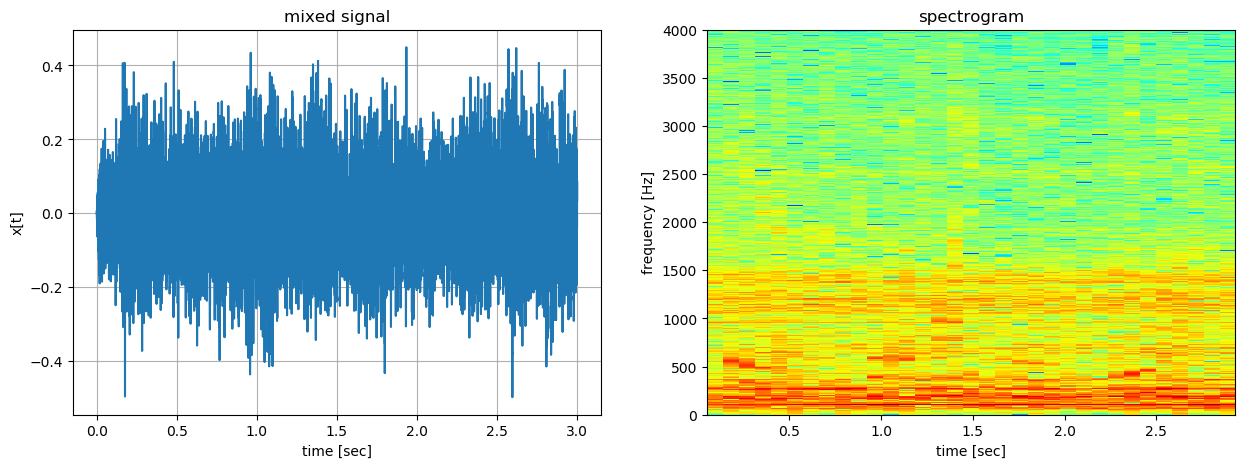

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_tot)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("mixed signal"), ax[2].set_title("spectrogram")
;

## Load parameters

In [5]:
params_1 = h5read(param_file_1, "parameters")
;

## Create generative model and algorithm

In [6]:
# create factor graphs
fg = FactorGraph()

# AR node (source 1)
@RV γ1 ~ ForneyLab.Gamma(placeholder(:a_γ1), placeholder(:b_γ1))
@RV θ1 ~ GaussianMeanPrecision(params_1["mean_theta"], params_1["precision_theta"])
@RV Sprev1 ~ GaussianMeanPrecision(placeholder(:μ_Sprev1, dims=(AR_order,)), placeholder(:Λ_Sprev1, dims=(AR_order, AR_order)))
@RV S1 ~ LAR.Autoregressive(θ1, Sprev1, γ1)

# AR node (source 1)
@RV γ2 ~ ForneyLab.Gamma(placeholder(:a_γ2), placeholder(:b_γ2))
@RV θ2 ~ GaussianMeanPrecision(placeholder(:μ_θ2, dims=(AR_order,)), placeholder(:Λ_θ2, dims=(AR_order,AR_order)))
@RV Sprev2 ~ GaussianMeanPrecision(placeholder(:μ_Sprev2, dims=(AR_order,)), placeholder(:Λ_Sprev2, dims=(AR_order, AR_order)))
@RV S2 ~ LAR.Autoregressive(θ2, Sprev2, γ2)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x1 ~ DotProduct(d, S1)
@RV x2 ~ DotProduct(d, S2)

@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x1 + x2 + v
placeholder(y, :y)


ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13653175742299541243 -->
 13653175742299541243 
 
 AR 
 autoregressive_1 
 
<!-- 9694772987024213616 -->
 9694772987024213616 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 13653175742299541243--9694772987024213616 -->
 13653175742299541243--9694772987024213616 
 
 θ1 
 1 out 
 3 θ 
 
<!-- 5720028189858148099 -->
 5720028189858148099 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 13653175742299541243--5720028189858148099 -->
 13653175742299541243--5720028189858148099 
 
 Sprev1 
 1 out 
 2 x 
 
<!-- 11511384409362129865 -->
 11511384409362129865 
 
 Gam 
 gamma_1 
 
<!-- 13653175742299541243--11511384409362129865 -->
 13653175742299541243--11511384409362129865 
 
 γ1 
 1 out 
 4 γ 
 
<!-- 295138344119985758 -->
 295138344119985758 
 
 clamp_2 
 
<!-- 2920671133275511493 -->
 2920671133275511493 
 
 placeholder_b_γ2 
 
<!-- 16124895146425106870 -->
 16124895146425106870 
 
 placeholder_μ_θ2 
 
<!-- 12430170178980216613 -->
 12430170178980216613 
 
 placeholder_y 
 
<!-- 7214729013197752101 -->
 7214729013197752101 
 
 + 
 addition_2 
 
<!-- 12430170178980216613--7214729013197752101 -->
 12430170178980216613--7214729013197752101 
 
 y 
 1 out 
 1 out 
 
<!-- 1820441135423799843 -->
 1820441135423799843 
 
 clamp_1 
 
<!-- 1253896667744148393 -->
 1253896667744148393 
 
 placeholder_μ_Sprev1 
 
<!-- 18166105498878096230 -->
 18166105498878096230 
 
 Gam 
 gamma_2 
 
<!-- 18166105498878096230--2920671133275511493 -->
 18166105498878096230--2920671133275511493 
 
 b_γ2 
 1 out 
 3 b 
 
<!-- 13738612490330291205 -->
 13738612490330291205 
 
 placeholder_a_γ2 
 
<!-- 18166105498878096230--13738612490330291205 -->
 18166105498878096230--13738612490330291205 
 
 a_γ2 
 1 out 
 2 a 
 
<!-- 10774956420323939741 -->
 10774956420323939741 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 10771037163995844571 -->
 10771037163995844571 
 
 placeholder_μ_Sprev2 
 
<!-- 10774956420323939741--10771037163995844571 -->
 10774956420323939741--10771037163995844571 
 
 μ_Sprev2 
 1 out 
 2 m 
 
<!-- 17966558440699990098 -->
 17966558440699990098 
 
 placeholder_Λ_Sprev2 
 
<!-- 10774956420323939741--17966558440699990098 -->
 10774956420323939741--17966558440699990098 
 
 Λ_Sprev2 
 1 out 
 3 w 
 
<!-- 14161330279854794395 -->
 14161330279854794395 
 
 AR 
 autoregressive_2 
 
<!-- 14161330279854794395--18166105498878096230 -->
 14161330279854794395--18166105498878096230 
 
 γ2 
 1 out 
 4 γ 
 
<!-- 14161330279854794395--10774956420323939741 -->
 14161330279854794395--10774956420323939741 
 
 Sprev2 
 1 out 
 2 x 
 
<!-- 16601753962268605052 -->
 16601753962268605052 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 14161330279854794395--16601753962268605052 -->
 14161330279854794395--16601753962268605052 
 
 θ2 
 1 out 
 3 θ 
 
<!-- 11020040794309174198 -->
 11020040794309174198 
 
 clamp_5 
 
<!-- 9694772987024213616--295138344119985758 -->
 9694772987024213616--295138344119985758 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 9694772987024213616--1820441135423799843 -->
 9694772987024213616--1820441135423799843 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 17229462865889647856 -->
 17229462865889647856 
 
 dot 
 dotproduct_1 
 
<!-- 17229462865889647856--13653175742299541243 -->
 17229462865889647856--13653175742299541243 
 
 S1 
 1 y 
 3 in2 
 
<!-- 16565114307154048219 -->
 16565114307154048219 
 
 clamp_3 
 
<!-- 17229462865889647856--16565114307154048219 -->
 17229462865889647856--16565114307154048219 
 
 clamp_3 
 1 out 
 2 in1 
 
<!-- 17207943164304444144 -->
 17207943164304444144 
 
 clamp_4 
 
<!-- 7324134637881

In [7]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S1, Sprev1, x1, γ1, θ1, S2, Sprev2, x2, γ2, θ2, ids=[:S1 :Sprev1 :x1 :γ1 :θ1 :S2 :Sprev2 :x2 :γ2 :θ2])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
;

## Perform inference

In [8]:
# priors
current1_μ_Sprev = randn(AR_order)
current1_Λ_Sprev = tiny*diagm(randn(AR_order))
current2_μ_Sprev = randn(AR_order)
current2_Λ_Sprev = tiny*diagm(randn(AR_order))
current1_μ_x = randn(1)
current1_Λ_x = tiny
current2_μ_x = randn(1)
current2_Λ_x = tiny
a_γ1_min = params_1["a_gamma"]
b_γ1_min = params_1["b_gamma"]
a_γ2_min = 1
b_γ2_min = 0.001
μ_θ_min = randn(AR_order)
Λ_θ_min = 1e1*Ic(AR_order)

# placeholders for predictions
x1_μ_pred = Float64[]
x1_Λ_pred = Float64[]
x2_μ_pred = Float64[]
x2_Λ_pred = Float64[]

# progress bar
p = Progress(length(x_tot), 1, "Observed ")

# initialize marginals and data dictionary
marginals = Dict()
data = Dict()
marginals[:γ1] = ProbabilityDistribution(Univariate, Gamma, a=params_1["a_gamma"], b=params_1["b_gamma"])
marginals[:γ2] = ProbabilityDistribution(Univariate, Gamma, a=a_γ2_min, b=b_γ2_min)

# loop through signal samples
for sp in 1:length(x_tot)
    
    # update progress bar
    update!(p, sp)
    
    # update marginals
    marginals[:θ1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_1["mean_theta"], w=params_1["precision_theta"])
    marginals[:Sprev1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current1_μ_Sprev, w=current1_Λ_Sprev)
    marginals[:x1] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=current1_μ_x, w=current1_Λ_x)
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=μ_θ_min, w=Λ_θ_min)
    marginals[:Sprev2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current2_μ_Sprev, w=current2_Λ_Sprev)    
    marginals[:x2] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=current2_μ_x, w=current2_Λ_x)
    
    # update data dictionary
    data = Dict(:y => x_tot[sp],
                :μ_Sprev1 => current1_μ_Sprev,
                :Λ_Sprev1 => current1_Λ_Sprev,
                :μ_Sprev2 => current2_μ_Sprev,
                :Λ_Sprev2 => current2_Λ_Sprev,
                :μ_θ2 => μ_θ_min,
                :Λ_θ2 => Λ_θ_min,
                :a_γ1 => a_γ1_min,
                :b_γ1 => b_γ1_min,
                :a_γ2 => a_γ2_min,
                :b_γ2 => b_γ2_min)      

    # perform VMP iterations
    for it = 1:iterations
        
        # perform inference
        data, marginals = step_all!(data, marginals)
        
    end
    
    # update current parameters
    current1_μ_Sprev = ForneyLab.unsafeMean(marginals[:S1])
    current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S1])
    current2_μ_Sprev = ForneyLab.unsafeMean(marginals[:S2])
    current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S2])
    current1_μ_x = ForneyLab.unsafeMean(marginals[:x1])
    current1_Λ_x = ForneyLab.unsafePrecision(marginals[:x1])
    current2_μ_x = ForneyLab.unsafeMean(marginals[:x2])
    current2_Λ_x = ForneyLab.unsafePrecision(marginals[:x2])
    #a_γ1_min = marginals[:γ1].params[:a]
    #b_γ1_min = marginals[:γ1].params[:b]
    a_γ2_min = marginals[:γ2].params[:a]
    b_γ2_min = marginals[:γ2].params[:b]
    μ_θ_min = ForneyLab.unsafeMean(marginals[:θ2])
    #Λ_θ_min = ForneyLab.unsafePrecision(marginals[:θ2])

    # save predictions of separation
    push!(x1_μ_pred, current1_μ_x)
    push!(x1_Λ_pred, current1_Λ_x)
    push!(x2_μ_pred, current2_μ_x)
    push!(x2_Λ_pred, current2_Λ_x)    
end
;

Observed 100%|██████████████████████████████████████████| Time: 0:05:17:04


## Airco sound

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCelbK6drY7O9ob5DsO3H474Vctu7GzKbuWhHO74dpiPA/pg7zj8BO778yuuxWLDLxZ2Mw8CBxPPMyfw7zOCfG88HfPPE5Auzz/uqO7gZROvc69C71B4Uo8N3yEPKHlND1hhv88wKPCPFcvxbrC6YC93JWovF9fLj2+sEQ98uQdvfNXSr09HM27GPssva1wYLxlhBi8OF3EvEKo/7tKeak8GLPGPCdYyTwSDU28mLuyOvQuHjtKe068yblTvChzRD3z82U9cBIaPe0Iw7sKfi69GirCvJ3IerucJoK7G6KevDjlHr0f0dI801yAPLmwXjshW728Z1HvvD6wEr3xkKa8yPA6PZ79bz1EeHO7E2CGvZI83zsjeoQ9yIS8PWJsTT34Kkq9P/SsvYpVoLznBm08NkWDvIZhgb2WgrC96C6MvVha2LzUejU9sLwtPFsCFzxctz+9lITSvUoEir3xXna8PfuuPJb7vjwqP0Y96iyTPXJSoz2MMuE8k/GXvNP27LuXR4o8mlaSPXbcqz3VZ0u8K4CXvWUzAL7e65K9zVhkvX4sIL2SRo+8OHifvFsID70cYDe98loovN3sDz1fb3A9qv42PWW8DTz6s5k9MtTUPVqHxT0BUa49SuK4PN60JT1k5xE9si8sPZgejz2E6XU91jnSPVefRz3BNZs9GDuHPdz5hjxUrgW8LUrMvFQuIrxtlDW9VDNLvSwLr73uP6O9H3HlvRrbKr7KiuW9qAKnvYwkkL1pOwy+1SUuvqYTQr5YafO9fY3VvQb2hL12pJG9uIEmvNCGT7rXZ8y5Agp+Pcyq9j2rVrM9kr4aPOyARD2pi7E9n4ngPRrr8j1IDJw9pArNPCXhMj17Ods8m/R9PRSylTwN6qw8+9QmPc0/cLseige9duKSPKQwqjzszAc9qGFoPTUR4T3TgOs9IdPtPQEahj3G6ZY9ZjiPPYvZqD0AWgk+0gDVPSNG8T3X9OA9FXIqPcq+FLtT6I+8GZbXvDK4CL1k3TC9ga8uvTfZrr26ks698n4zvqlDLb7e5Pu91TGJvbh3BL0CbAW9OgBKvK7kvbwOd4G9pDnovL4+Fj0uOPI8FTOZPOFsNL1QqZy7OQoevJcwyLwvTAQ8DmEfPBQhDrxnqc68uNQ4vdxpIr3hoUu86LA/vGKpGL1D9ri9dCXdvd0UVb1DsR29yIlsvZWhv70iOg2+oa3bvamKqr1FQJu9DN6jvYHiXb1/e6O7IguvPMzhWT3Xp2Q9uTV/vBUSEb3cXCE9xtGcPXYLBD7Qehg+bUgOPux0MT7SHjM+n/D1PXz1+D3Vr7k9qxSzPUpIsD2rprE9rspMPVgObr2wOgC+RZoWvtEenr3E+ma9RkwrvQZWmbwUvqS9RLwTvnNsPb55CZ69rEWQPLPCID3DqCQ9QzVCPGP+gzyDYpm8PI2tvHsk8zwah8A9iMigPYZ5Kj1IxxQ99x2kvDAuKb2SeLe8k2igvOcLCL1BvLe9QrAAvmA0z71x/+O9DM3wvQEQO73XQlG9mXBhvbraDr0z8V28ivTmvCdmPjzoIJy8KUKHvGBED7xMa+W8Y+F7vL7XbTugPzY8rSliui3zrD1igqo9KOGWPcV8XDxZNL27O7NKvIGpFrz8AAa90OomvdB8Ar0kAnK9xgE1vUCLx7w5oag8UNqWPUGLvD1Q9SA84D7bvB58ND1Iosw98u8xPqnoJD4EuRg+/38qPu3iNT4ZSx0+L3E8Pm+YSD5FCRM+sv4lPgGwkz3laW09eUzrPTsMtD2yyKc84zW6vF/Zn70dPrO97tmGvc5GKL0/HjG9/zVMvVydsL3zPSW+w8Ukvnd4Jr5a/cC9PPlmvTv1Cr00LYY7z0WsO/nvx7wehsI7krUlPYH40z2n2/k9YUADPoizyj2RBss9W4I3PckGpDxGEzA8fNKTPHXymDyKPJk7u8TSvBCPeL0VtLS9nzQQvrReFL5d59a9T42lvYdKnb1vwqW9ko++vSisAL6pi/C9nBfwvWXwwb27Kgi+ZIUHvoQxob3CcN28BAu8vMDGtL1RFm69J7RhvH0soryG1RK8gDckPYzwPD1+rYM9K2dFPQ5q2Tz/nQI8AK0jPYXUTryzpom9K3/mPHx9AD7UagI+x+xbPZBRQ704asm9vkSIvfxMw7xhNdw8/mUDPk2z6j1M+7s9q/dqPYjfUD1/SiI+F0BqPiChLj445+49zlfxPS4bDz4z3xE+X4UjPt7vED6Drl09/G4VPA9J0jzUD8A8kV2yPHO9ELw5hJy97cgYvnDo5b3hUWG9IgdfvQDg9bzaa629nL3dvSTZ/L28rsG9ltTYvUg+1b3uMsS9BnGMvcMWYb2ldY29z4SUvSWOtb35+gS9550KPGb4yjw9bfE7KFbevBFoh71kBlS9jI8mPZE0mj2FGcE8e4WfvVS/Cb4znAO+97a5vYWgm7y0JPI75UgkvXjghb337bC9suVlvDz9fD3hMIc9yrJWPRk6qLtgpmE9cgdxPVNrpD2LR2E9rTvNPY0NyD3G5es9+IEUPngQBT41O9I9gDDePXa33T1QOts9bjjJPeALkz07pTE8Q8LSPFBrlzpbu9o7eBsfPSs967pjEx69MV1bvVivS73n60+9L5BNvfGShL3iqlO9tV6OvbSIezt7+sA8HPoAvK7LKb2TZoq9HuM8vbqSPD1vwM09kSDjPZPcyz1t4rw9MKkEvW1bH720z3C7JKgOPd3eG72PGCC9JYFovT1w1L0zfpW9XluHvdVG5b14aAC+Y0cIvpDetb17tIS8xRgcvalvrr1NO8m9FWFMvcsw27yWPXy8FcY/PfeU8T1kqHo9yowHPR/0kzw8ttU8xYmMPZaM0T3tSY09B4QyPebaID2x6Cw9WnZTPY1iUz1coXY85eHXO0HmOjzbqBy9F/lgvVyn6b04xae9CwaRvJ8ywjy+EgE8CV+gvYSmy73dHEq9RV78PKoBmj22Kiw9DKXdvDs6Qb1d1uA7nNiyPXggMD5oz/Y9wpm8PUD5SD0Jh6I9nUTaPedvoj2vbIE9ruEFvZszDb27HIk8D68wPZw+mjwARCi8vPMUPdQXsT0+GXQ9+AGcPKGCsrxEPUG9o64tvBOdtD3iYak9LNDEOzHW+byFtpu9fwsVvBBnjz2BDa092N98PRm/l7zri2s7TFBfvTTjub3evCO92gEQvVjKkrwiNE+993mkvaKcCr7QKQu+LDW0vTk0Ab0ICqU8UgW4vdtTJ77x6Da+1gcUvpjTsr35WJ48EghNPSd+trzia7W9Ae2yvUZegL0+yS683VbOO84ySrxJdgi9BlQwvNtIRT2djYM9Ova1PXBKez0CcOM8eiJsPXUsPT1f94i7DL0WPAuXD73U+Ru81X36vGJp2jyQq309TbdaPVp6iD3S8w48WmGvvSDkpb3TKiO9kFzPPOIylD3s4Lc8dvHKOz4AIbxVtjS89uyLPfjJIT7I99c9eQV/PRNsPT0XkEY8SdbPPAzzuT1nsK4995H4PG9NQj3s8bE8a+ZHPQDNhD0fyt89mPm/PYkduz1pTYA9NPnDPDa5WbxXKqA9s/JSPSeCnT1EoPM94y6xPVBQST0fTPy6QH4svJ0NjLwvlSe9km2JvaUDdb2ASXS9ssS7vX0kSL1IIcG92qr6vSZuFr46lKu9jrVkvXg1Tb2WxLO9Xc8ivtXqFr6M/fu9Vy/xvQnI771wyha+LaoAvh5XFL6TMTy+Zyctvnd2Fr7u1CK+zDbkvT0Zw7wC8F687IB+vRuFA76mUHy9s9BfPE69hj06S/M9/vATPhc29j2B7go+vKnVPQ7OuT3lmQA+qTsFPt1wCj7Rwrc9WgTpPe2cDD51rdA96915PWwPvj103

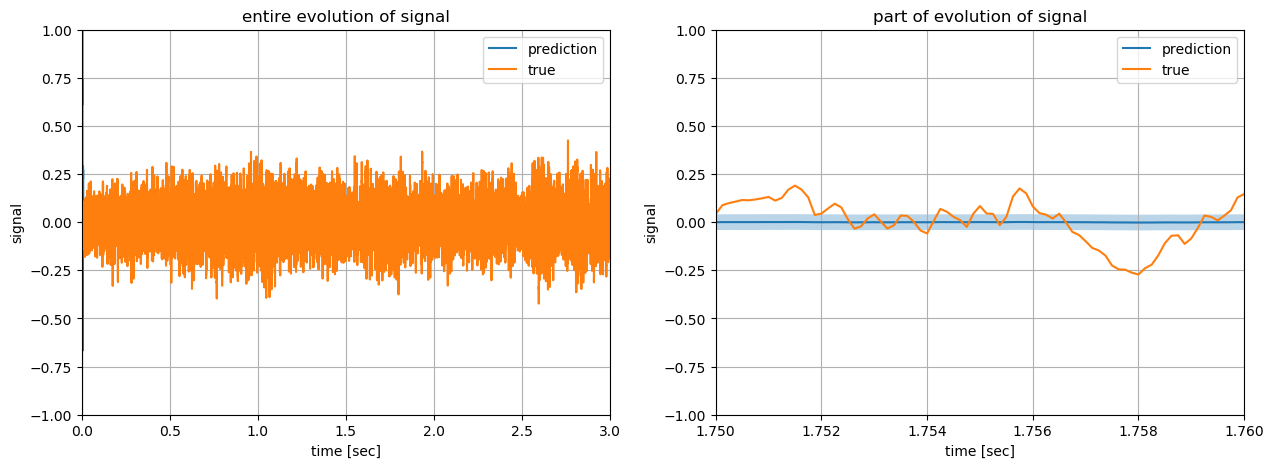

In [9]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t[1:end], x1_μ_pred[1:end], label="prediction"), ax[2].plot(t[1:end], x1_μ_pred[1:end], label="prediction")

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], x_1[1:end], label="true"), ax[2].plot(t[1:end], x_1[1:end], label="true") 
ax[2].fill_between(t,x1_μ_pred .- 1 ./sqrt.(x1_Λ_pred), x1_μ_pred .+ 1 ./sqrt.(x1_Λ_pred), alpha=0.3)

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1,1), ax[1].set_ylim(-1,1)

# create audioplayers
audioplayers(x_tot, x_1, x1_μ_pred, fs=fs_desired)
;

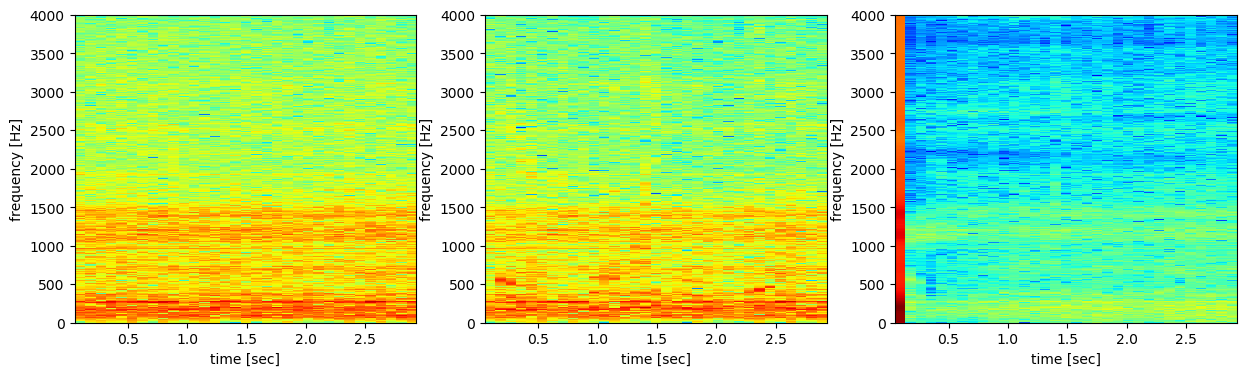

In [10]:
_, ax = plt.subplots(ncols=3, figsize=(15,4))
plot_spectrogram(spectrogram(x_1, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[1])
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])
plot_spectrogram(spectrogram(x1_μ_pred, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])
;

## speech

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCelbK6drY7O9ob5DsO3H474Vctu7GzKbuWhHO74dpiPA/pg7zj8BO778yuuxWLDLxZ2Mw8CBxPPMyfw7zOCfG88HfPPE5Auzz/uqO7gZROvc69C71B4Uo8N3yEPKHlND1hhv88wKPCPFcvxbrC6YC93JWovF9fLj2+sEQ98uQdvfNXSr09HM27GPssva1wYLxlhBi8OF3EvEKo/7tKeak8GLPGPCdYyTwSDU28mLuyOvQuHjtKe068yblTvChzRD3z82U9cBIaPe0Iw7sKfi69GirCvJ3IerucJoK7G6KevDjlHr0f0dI801yAPLmwXjshW728Z1HvvD6wEr3xkKa8yPA6PZ79bz1EeHO7E2CGvZI83zsjeoQ9yIS8PWJsTT34Kkq9P/SsvYpVoLznBm08NkWDvIZhgb2WgrC96C6MvVha2LzUejU9sLwtPFsCFzxctz+9lITSvUoEir3xXna8PfuuPJb7vjwqP0Y96iyTPXJSoz2MMuE8k/GXvNP27LuXR4o8mlaSPXbcqz3VZ0u8K4CXvWUzAL7e65K9zVhkvX4sIL2SRo+8OHifvFsID70cYDe98loovN3sDz1fb3A9qv42PWW8DTz6s5k9MtTUPVqHxT0BUa49SuK4PN60JT1k5xE9si8sPZgejz2E6XU91jnSPVefRz3BNZs9GDuHPdz5hjxUrgW8LUrMvFQuIrxtlDW9VDNLvSwLr73uP6O9H3HlvRrbKr7KiuW9qAKnvYwkkL1pOwy+1SUuvqYTQr5YafO9fY3VvQb2hL12pJG9uIEmvNCGT7rXZ8y5Agp+Pcyq9j2rVrM9kr4aPOyARD2pi7E9n4ngPRrr8j1IDJw9pArNPCXhMj17Ods8m/R9PRSylTwN6qw8+9QmPc0/cLseige9duKSPKQwqjzszAc9qGFoPTUR4T3TgOs9IdPtPQEahj3G6ZY9ZjiPPYvZqD0AWgk+0gDVPSNG8T3X9OA9FXIqPcq+FLtT6I+8GZbXvDK4CL1k3TC9ga8uvTfZrr26ks698n4zvqlDLb7e5Pu91TGJvbh3BL0CbAW9OgBKvK7kvbwOd4G9pDnovL4+Fj0uOPI8FTOZPOFsNL1QqZy7OQoevJcwyLwvTAQ8DmEfPBQhDrxnqc68uNQ4vdxpIr3hoUu86LA/vGKpGL1D9ri9dCXdvd0UVb1DsR29yIlsvZWhv70iOg2+oa3bvamKqr1FQJu9DN6jvYHiXb1/e6O7IguvPMzhWT3Xp2Q9uTV/vBUSEb3cXCE9xtGcPXYLBD7Qehg+bUgOPux0MT7SHjM+n/D1PXz1+D3Vr7k9qxSzPUpIsD2rprE9rspMPVgObr2wOgC+RZoWvtEenr3E+ma9RkwrvQZWmbwUvqS9RLwTvnNsPb55CZ69rEWQPLPCID3DqCQ9QzVCPGP+gzyDYpm8PI2tvHsk8zwah8A9iMigPYZ5Kj1IxxQ99x2kvDAuKb2SeLe8k2igvOcLCL1BvLe9QrAAvmA0z71x/+O9DM3wvQEQO73XQlG9mXBhvbraDr0z8V28ivTmvCdmPjzoIJy8KUKHvGBED7xMa+W8Y+F7vL7XbTugPzY8rSliui3zrD1igqo9KOGWPcV8XDxZNL27O7NKvIGpFrz8AAa90OomvdB8Ar0kAnK9xgE1vUCLx7w5oag8UNqWPUGLvD1Q9SA84D7bvB58ND1Iosw98u8xPqnoJD4EuRg+/38qPu3iNT4ZSx0+L3E8Pm+YSD5FCRM+sv4lPgGwkz3laW09eUzrPTsMtD2yyKc84zW6vF/Zn70dPrO97tmGvc5GKL0/HjG9/zVMvVydsL3zPSW+w8Ukvnd4Jr5a/cC9PPlmvTv1Cr00LYY7z0WsO/nvx7wehsI7krUlPYH40z2n2/k9YUADPoizyj2RBss9W4I3PckGpDxGEzA8fNKTPHXymDyKPJk7u8TSvBCPeL0VtLS9nzQQvrReFL5d59a9T42lvYdKnb1vwqW9ko++vSisAL6pi/C9nBfwvWXwwb27Kgi+ZIUHvoQxob3CcN28BAu8vMDGtL1RFm69J7RhvH0soryG1RK8gDckPYzwPD1+rYM9K2dFPQ5q2Tz/nQI8AK0jPYXUTryzpom9K3/mPHx9AD7UagI+x+xbPZBRQ704asm9vkSIvfxMw7xhNdw8/mUDPk2z6j1M+7s9q/dqPYjfUD1/SiI+F0BqPiChLj445+49zlfxPS4bDz4z3xE+X4UjPt7vED6Drl09/G4VPA9J0jzUD8A8kV2yPHO9ELw5hJy97cgYvnDo5b3hUWG9IgdfvQDg9bzaa629nL3dvSTZ/L28rsG9ltTYvUg+1b3uMsS9BnGMvcMWYb2ldY29z4SUvSWOtb35+gS9550KPGb4yjw9bfE7KFbevBFoh71kBlS9jI8mPZE0mj2FGcE8e4WfvVS/Cb4znAO+97a5vYWgm7y0JPI75UgkvXjghb337bC9suVlvDz9fD3hMIc9yrJWPRk6qLtgpmE9cgdxPVNrpD2LR2E9rTvNPY0NyD3G5es9+IEUPngQBT41O9I9gDDePXa33T1QOts9bjjJPeALkz07pTE8Q8LSPFBrlzpbu9o7eBsfPSs967pjEx69MV1bvVivS73n60+9L5BNvfGShL3iqlO9tV6OvbSIezt7+sA8HPoAvK7LKb2TZoq9HuM8vbqSPD1vwM09kSDjPZPcyz1t4rw9MKkEvW1bH720z3C7JKgOPd3eG72PGCC9JYFovT1w1L0zfpW9XluHvdVG5b14aAC+Y0cIvpDetb17tIS8xRgcvalvrr1NO8m9FWFMvcsw27yWPXy8FcY/PfeU8T1kqHo9yowHPR/0kzw8ttU8xYmMPZaM0T3tSY09B4QyPebaID2x6Cw9WnZTPY1iUz1coXY85eHXO0HmOjzbqBy9F/lgvVyn6b04xae9CwaRvJ8ywjy+EgE8CV+gvYSmy73dHEq9RV78PKoBmj22Kiw9DKXdvDs6Qb1d1uA7nNiyPXggMD5oz/Y9wpm8PUD5SD0Jh6I9nUTaPedvoj2vbIE9ruEFvZszDb27HIk8D68wPZw+mjwARCi8vPMUPdQXsT0+GXQ9+AGcPKGCsrxEPUG9o64tvBOdtD3iYak9LNDEOzHW+byFtpu9fwsVvBBnjz2BDa092N98PRm/l7zri2s7TFBfvTTjub3evCO92gEQvVjKkrwiNE+993mkvaKcCr7QKQu+LDW0vTk0Ab0ICqU8UgW4vdtTJ77x6Da+1gcUvpjTsr35WJ48EghNPSd+trzia7W9Ae2yvUZegL0+yS683VbOO84ySrxJdgi9BlQwvNtIRT2djYM9Ova1PXBKez0CcOM8eiJsPXUsPT1f94i7DL0WPAuXD73U+Ru81X36vGJp2jyQq309TbdaPVp6iD3S8w48WmGvvSDkpb3TKiO9kFzPPOIylD3s4Lc8dvHKOz4AIbxVtjS89uyLPfjJIT7I99c9eQV/PRNsPT0XkEY8SdbPPAzzuT1nsK4995H4PG9NQj3s8bE8a+ZHPQDNhD0fyt89mPm/PYkduz1pTYA9NPnDPDa5WbxXKqA9s/JSPSeCnT1EoPM94y6xPVBQST0fTPy6QH4svJ0NjLwvlSe9km2JvaUDdb2ASXS9ssS7vX0kSL1IIcG92qr6vSZuFr46lKu9jrVkvXg1Tb2WxLO9Xc8ivtXqFr6M/fu9Vy/xvQnI771wyha+LaoAvh5XFL6TMTy+Zyctvnd2Fr7u1CK+zDbkvT0Zw7wC8F687IB+vRuFA76mUHy9s9BfPE69hj06S/M9/vATPhc29j2B7go+vKnVPQ7OuT3lmQA+qTsFPt1wCj7Rwrc9WgTpPe2cDD51rdA96915PWwPvj103

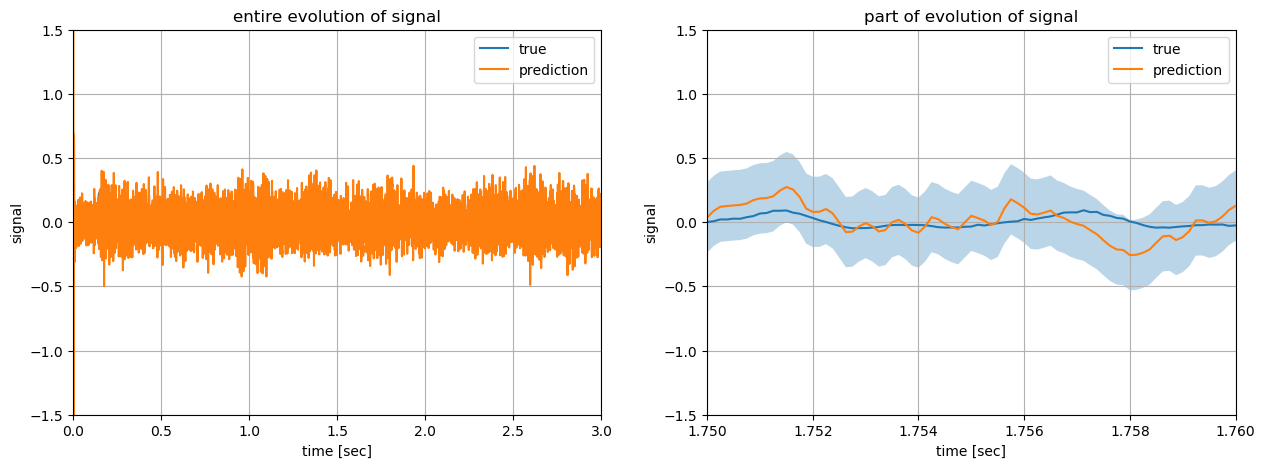

In [11]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))


# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_2, label="true"), ax[2].plot(t, x_2, label="true") 
# plot prediction of frequency component
ax[1].plot(t, x2_μ_pred, label="prediction"), ax[2].plot(t, x2_μ_pred, label="prediction")
ax[2].fill_between(t,x2_μ_pred .- 1 ./sqrt.(x2_Λ_pred), x2_μ_pred .+ 1 ./sqrt.(x2_Λ_pred), alpha=0.3)

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-1.5,1.5)

# create audioplayers
audioplayers(x_tot, x_2, x2_μ_pred, fs=fs_desired)
;

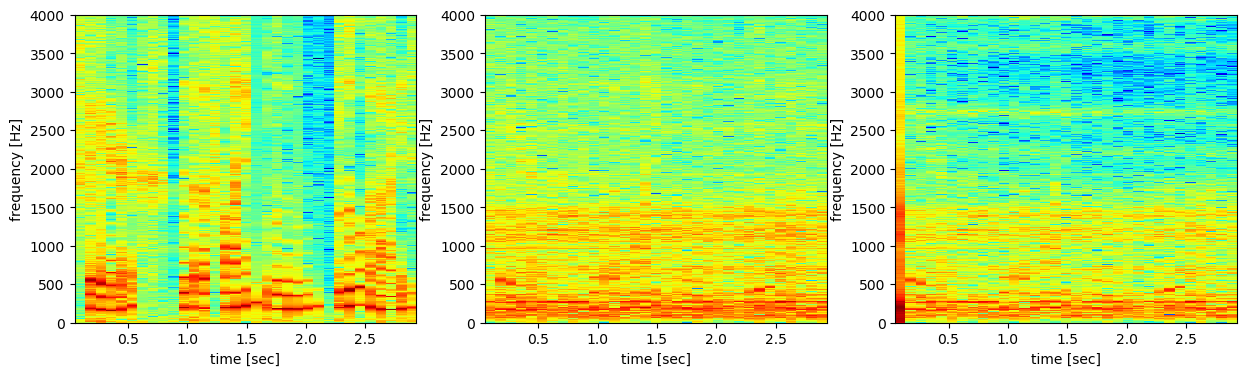

In [12]:
_, ax = plt.subplots(ncols=3, figsize=(15,4))
plot_spectrogram(spectrogram(x_2, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[1])
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])
plot_spectrogram(spectrogram(x2_μ_pred, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])
;